In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/fractaluser/Downloads/prototype')
from keras.layers import Input, Dense
from keras.models import Model
from keras import callbacks
import time, random
import scipy
import seaborn as sns
sns.set(palette='dark', font_scale = 1)
pd.set_option('display.max_columns', None)
from scipy.spatial import distance

/home/fractaluser/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(216)
from tensorflow import set_random_seed

sample_data = pd.read_csv('sample_simulated_transaction_history.csv')
sample_data.date = pd.to_datetime(sample_data.date)

In [3]:
sample_data.head()

,id,date,purchaseamount,dept,category,chain,purchasequantity,company,brand,productsize,productmeasure
0,Donor_1,2015-03-04,203.174075,Sports,Sports,site_1,1,Company1,Brand3,x,xx
1,Donor_1,2016-04-17,300.639489,Sports,Sports,site_1,1,Company1,Brand1,x,xx
2,Donor_1,2015-04-06,374.096413,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand1,x,xx
3,Donor_1,2015-09-04,348.347601,Women Apparel,Dresses/Jumpsuits,site_1,1,Company2,Brand3,x,xx
4,Donor_1,2016-03-08,287.477333,Women Apparel,Dresses/Jumpsuits,site_1,1,Company1,Brand3,x,xx


In [4]:
df = sample_data[(sample_data.category == 'Tees & Polos')].reset_index(drop = True)[['id','date', 'purchaseamount']]
df = df.pivot_table(index=['id'], columns='date', values='purchaseamount', aggfunc='mean').fillna(0).T

In [5]:
pre_start_date = '2015-01-01'
pre_end_date = '2015-12-31'

In [6]:
df['dummy_donor_1'] = pd.DataFrame({'dummy_donor_1':df.iloc[:,-1].shift()})
df['dummy_donor_2'] = pd.DataFrame({'dummy_donor_2':df.iloc[:,-2].shift(-1)})
df['dummy_donor_3'] = pd.DataFrame({'dummy_donor_3':df.iloc[:,-3]*1.7})
df = df.fillna(0)

In [7]:
xtrain1 = df[pre_start_date:pre_end_date][df.columns[:5000]].values.T
xtest1 = df[pre_start_date:pre_end_date][df.columns[5000:]].values.T

In [8]:
columns = (xtrain1 == 0).sum(0)
rows = (xtrain1 == 0).sum(1)
print(rows.sum()*100/(xtrain1.shape[0]*xtrain1.shape[1]))

96.51298630136986


In [9]:
columns = (xtest1 == 0).sum(0)
rows = (xtest1 == 0).sum(1)
print(rows.sum()*100/(xtest1.shape[0]*xtest1.shape[1]))

96.52494571081277


In [103]:
DIM = 25

encoding_dim1 = DIM*5
encoding_dim2 = DIM*4
encoding_dim3 = DIM*3
encoding_dim4 = DIM*2
encoding_dim5 = DIM

In [104]:
inputs = Input(shape=(xtrain1.shape[1],))

encoded1 = Dense(encoding_dim1, activation='tanh')(inputs)
encoded2 = Dense(encoding_dim2, activation='tanh')(encoded1)
encoded3 = Dense(encoding_dim3, activation='tanh')(encoded2)
encoded4 = Dense(encoding_dim4, activation='tanh')(encoded3)
encoded5 = Dense(encoding_dim5, activation='tanh')(encoded4)
decoded1 = Dense(encoding_dim4, activation='tanh')(encoded5)
decoded2 = Dense(encoding_dim3, activation='tanh')(decoded1)
decoded3 = Dense(encoding_dim2, activation='tanh')(decoded2)
decoded4 = Dense(encoding_dim1, activation='tanh')(decoded3)
decoded5 = Dense(xtrain1.shape[1], activation='softmax')(decoded4)

autoencoder = Model(inputs, decoded5)
encoder = Model(inputs, encoded5)
hidden_1 = Model(inputs, encoded1)
hidden_2 = Model(inputs, encoded2)
hidden_3 = Model(inputs, encoded3)

In [105]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 125)               45750     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               12600     
_________________________________________________________________
dense_23 (Dense)             (None, 75)                7575      
_________________________________________________________________
dense_24 (Dense)             (None, 50)                3800      
_________________________________________________________________
dense_25 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_26 (Dense)             (None, 50)                1300      
__________

In [106]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 365)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 125)               45750     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               12600     
_________________________________________________________________
dense_23 (Dense)             (None, 75)                7575      
_________________________________________________________________
dense_24 (Dense)             (None, 50)                3800      
_________________________________________________________________
dense_25 (Dense)             (None, 25)                1275      
Total params: 71,000
Trainable params: 71,000
Non-trainable params: 0
_________________________________________________________________


In [107]:
xtrain1 = np.where(xtrain1>0, 1, 0)
xtest1 = np.where(xtest1>0, 1, 0)

In [130]:
xtrain1.shape

(5000, 365)

In [108]:
set_random_seed(216)
EPOCHS = 1000
BATCH_SIZE = 500
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy')
history = autoencoder.fit(xtrain1, xtrain1, epochs=EPOCHS, verbose = 1, batch_size=BATCH_SIZE, shuffle=True,
                  callbacks = [callbacks.EarlyStopping(monitor='loss', patience=10, mode='auto')], validation_data = (xtest1, xtest1))

Train on 5000 samples, validate on 1003 samples
Epoch 1/1000
5000/5000 [==============================] - 2s 308us/step - loss: 74.5306 - val_loss: 73.3649
Epoch 2/1000
5000/5000 [==============================] - 1s 143us/step - loss: 72.7388 - val_loss: 71.4391
Epoch 3/1000
5000/5000 [==============================] - 1s 131us/step - loss: 70.9313 - val_loss: 69.8981
Epoch 4/1000
5000/5000 [==============================] - 1s 130us/step - loss: 69.5422 - val_loss: 68.7383
Epoch 5/1000
5000/5000 [==============================] - 1s 131us/step - loss: 68.3702 - val_loss: 67.7023
Epoch 6/1000
5000/5000 [==============================] - 1s 155us/step - loss: 67.3073 - val_loss: 66.7661
Epoch 7/1000
5000/5000 [==============================] - 1s 141us/step - loss: 66.3148 - val_loss: 65.8996
Epoch 8/1000
5000/5000 [==============================] - 1s 136us/step - loss: 65.4451 - val_loss: 65.1435
Epoch 9/1000
5000/5000 [==============================] - 1s 142us/step - loss: 64.6497 

Epoch 76/1000
5000/5000 [==============================] - 1s 109us/step - loss: 49.3099 - val_loss: 50.5566
Epoch 77/1000
5000/5000 [==============================] - 1s 111us/step - loss: 49.2105 - val_loss: 50.4562
Epoch 78/1000
5000/5000 [==============================] - 1s 112us/step - loss: 49.1152 - val_loss: 50.3795
Epoch 79/1000
5000/5000 [==============================] - 1s 118us/step - loss: 49.0169 - val_loss: 50.2999
Epoch 80/1000
5000/5000 [==============================] - 1s 137us/step - loss: 48.9129 - val_loss: 50.2024
Epoch 81/1000
5000/5000 [==============================] - 1s 111us/step - loss: 48.8152 - val_loss: 50.1561
Epoch 82/1000
5000/5000 [==============================] - 1s 111us/step - loss: 48.7219 - val_loss: 50.0715
Epoch 83/1000
5000/5000 [==============================] - 1s 123us/step - loss: 48.6353 - val_loss: 49.9871
Epoch 84/1000
5000/5000 [==============================] - 1s 114us/step - loss: 48.5376 - val_loss: 49.9362
Epoch 85/1000
5000/

5000/5000 [==============================] - 1s 123us/step - loss: 43.7783 - val_loss: 46.6393
Epoch 151/1000
5000/5000 [==============================] - 1s 141us/step - loss: 43.7132 - val_loss: 46.6053
Epoch 152/1000
5000/5000 [==============================] - 1s 136us/step - loss: 43.6642 - val_loss: 46.5442
Epoch 153/1000
5000/5000 [==============================] - 1s 125us/step - loss: 43.6090 - val_loss: 46.5447
Epoch 154/1000
5000/5000 [==============================] - 1s 137us/step - loss: 43.5574 - val_loss: 46.4738
Epoch 155/1000
5000/5000 [==============================] - 1s 144us/step - loss: 43.5055 - val_loss: 46.4561
Epoch 156/1000
5000/5000 [==============================] - 1s 154us/step - loss: 43.4457 - val_loss: 46.4528
Epoch 157/1000
5000/5000 [==============================] - 1s 151us/step - loss: 43.3922 - val_loss: 46.4330
Epoch 158/1000
5000/5000 [==============================] - 1s 138us/step - loss: 43.3612 - val_loss: 46.3877
Epoch 159/1000
5000/5000 

5000/5000 [==============================] - 1s 109us/step - loss: 40.7727 - val_loss: 45.4997
Epoch 225/1000
5000/5000 [==============================] - 1s 118us/step - loss: 40.7345 - val_loss: 45.4800
Epoch 226/1000
5000/5000 [==============================] - 1s 115us/step - loss: 40.7023 - val_loss: 45.4897
Epoch 227/1000
5000/5000 [==============================] - 1s 114us/step - loss: 40.6794 - val_loss: 45.4950
Epoch 228/1000
5000/5000 [==============================] - 1s 109us/step - loss: 40.6681 - val_loss: 45.4838
Epoch 229/1000
5000/5000 [==============================] - 1s 113us/step - loss: 40.6329 - val_loss: 45.4722
Epoch 230/1000
5000/5000 [==============================] - 1s 114us/step - loss: 40.5907 - val_loss: 45.4837
Epoch 231/1000
5000/5000 [==============================] - 1s 119us/step - loss: 40.5436 - val_loss: 45.4279
Epoch 232/1000
5000/5000 [==============================] - 1s 109us/step - loss: 40.5055 - val_loss: 45.4346
Epoch 233/1000
5000/5000 

5000/5000 [==============================] - 1s 114us/step - loss: 38.9992 - val_loss: 45.6357
Epoch 299/1000
5000/5000 [==============================] - 1s 120us/step - loss: 38.9748 - val_loss: 45.6179
Epoch 300/1000
5000/5000 [==============================] - 1s 120us/step - loss: 38.9685 - val_loss: 45.5746
Epoch 301/1000
5000/5000 [==============================] - 1s 119us/step - loss: 38.9564 - val_loss: 45.6866
Epoch 302/1000
5000/5000 [==============================] - 1s 113us/step - loss: 38.9425 - val_loss: 45.6637
Epoch 303/1000
5000/5000 [==============================] - 1s 141us/step - loss: 38.9259 - val_loss: 45.6604
Epoch 304/1000
5000/5000 [==============================] - 1s 109us/step - loss: 38.9134 - val_loss: 45.7084
Epoch 305/1000
5000/5000 [==============================] - 1s 110us/step - loss: 38.9086 - val_loss: 45.6754
Epoch 306/1000
5000/5000 [==============================] - 1s 120us/step - loss: 38.8992 - val_loss: 45.7416
Epoch 307/1000
5000/5000 

5000/5000 [==============================] - 1s 116us/step - loss: 37.8885 - val_loss: 46.2757
Epoch 373/1000
5000/5000 [==============================] - 1s 114us/step - loss: 37.8853 - val_loss: 46.3263
Epoch 374/1000
5000/5000 [==============================] - 1s 111us/step - loss: 37.8614 - val_loss: 46.3197
Epoch 375/1000
5000/5000 [==============================] - 1s 117us/step - loss: 37.8340 - val_loss: 46.2653
Epoch 376/1000
5000/5000 [==============================] - 1s 113us/step - loss: 37.8022 - val_loss: 46.2387
Epoch 377/1000
5000/5000 [==============================] - 1s 140us/step - loss: 37.7810 - val_loss: 46.3295
Epoch 378/1000
5000/5000 [==============================] - 1s 115us/step - loss: 37.7528 - val_loss: 46.2932
Epoch 379/1000
5000/5000 [==============================] - 1s 109us/step - loss: 37.7319 - val_loss: 46.3377
Epoch 380/1000
5000/5000 [==============================] - 1s 110us/step - loss: 37.7171 - val_loss: 46.3438
Epoch 381/1000
5000/5000 

5000/5000 [==============================] - 1s 130us/step - loss: 37.0836 - val_loss: 47.0930
Epoch 447/1000
5000/5000 [==============================] - 1s 129us/step - loss: 37.0693 - val_loss: 47.0644
Epoch 448/1000
5000/5000 [==============================] - 1s 127us/step - loss: 37.0690 - val_loss: 47.0633
Epoch 449/1000
5000/5000 [==============================] - 1s 124us/step - loss: 37.0869 - val_loss: 47.0941
Epoch 450/1000
5000/5000 [==============================] - 1s 144us/step - loss: 37.0448 - val_loss: 47.0696
Epoch 451/1000
5000/5000 [==============================] - 1s 126us/step - loss: 37.0031 - val_loss: 47.0400
Epoch 452/1000
5000/5000 [==============================] - 1s 135us/step - loss: 36.9791 - val_loss: 47.1434
Epoch 453/1000
5000/5000 [==============================] - 1s 126us/step - loss: 36.9646 - val_loss: 47.0928
Epoch 454/1000
5000/5000 [==============================] - 1s 135us/step - loss: 36.9212 - val_loss: 47.0166
Epoch 455/1000
5000/5000 

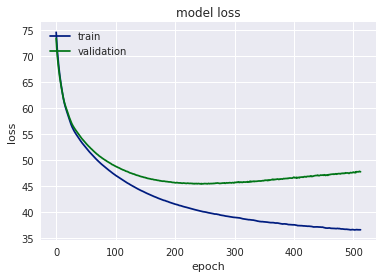

In [109]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

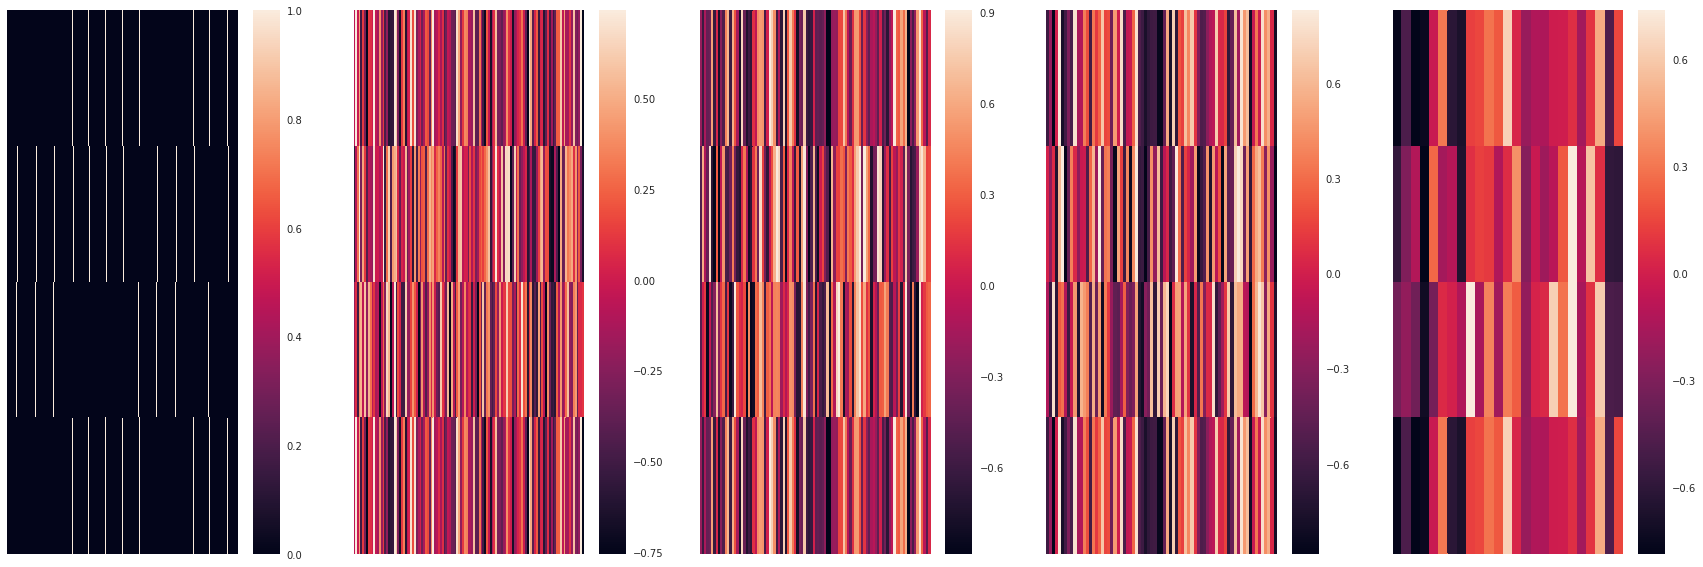

In [110]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(ncols=5, sharey=True, figsize = (30,10))
sns.heatmap(xtest1[-4:], xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax1)
sns.heatmap(hidden_1.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax2)
sns.heatmap(hidden_2.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax3)
sns.heatmap(hidden_3.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax4)
sns.heatmap(encoder.predict(xtest1[-4:]), xticklabels=False, yticklabels=False, robust = True, square=False, ax=ax5)
plt.show()

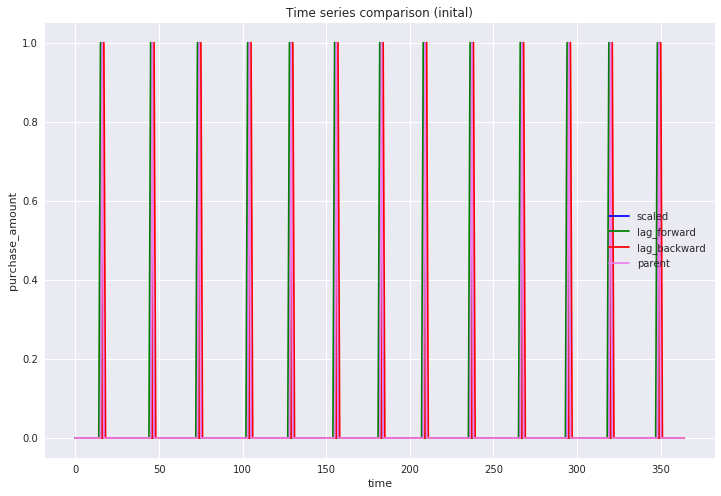

In [111]:
plt.figure(figsize = (12,8))
plt.plot(xtest1[-1], color = 'blue', label = 'scaled')
plt.plot(xtest1[-2], color = 'green', label = 'lag_forward')
plt.plot(xtest1[-3], color = 'red', label = 'lag_backward')
plt.plot(xtest1[-4], color = 'violet', label = 'parent')
plt.title('Time series comparison (inital)')
plt.legend(loc = 'best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [112]:
encoded_mat = encoder.predict(xtrain1)
encoded_mat_test = encoder.predict(xtest1)

decoded_mat = autoencoder.predict(xtrain1)
decoded_mat_test = autoencoder.predict(xtest1)

/home/fractaluser/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


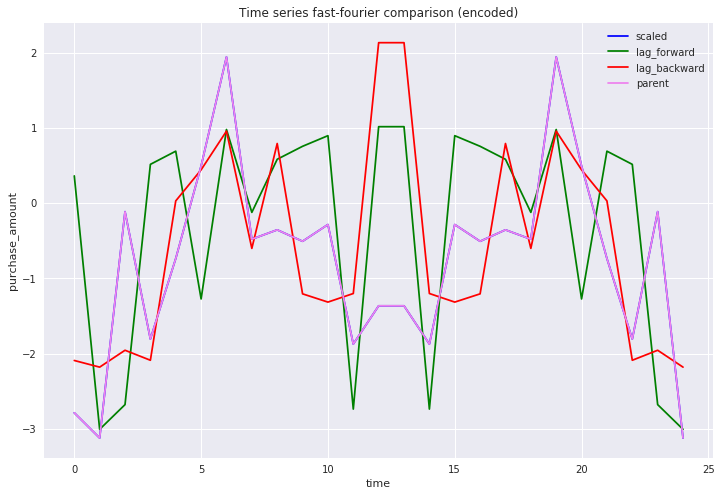

In [113]:
plt.figure(figsize = (12,8))
plt.plot(np.fft.fft(encoded_mat_test[-1])[-30:], color = 'blue', label = 'scaled')
plt.plot(np.fft.fft(encoded_mat_test[-2])[-30:], color = 'green', label = 'lag_forward')
plt.plot(np.fft.fft(encoded_mat_test[-3])[-30:], color = 'red', label = 'lag_backward')
plt.plot(np.fft.fft(encoded_mat_test[-4])[-30:], color = 'violet', label = 'parent')
plt.title('Time series fast-fourier comparison (encoded)')
plt.legend(loc='best')
plt.ylabel('purchase_amount')
plt.xlabel('time')
plt.show()

In [114]:
encoded_df = pd.DataFrame(encoded_mat)
encoded_df.insert(loc=0, column='id', value=df.columns[:5000].values)
encoded_df = encoded_df.set_index(encoded_df.id).drop(labels = ['id'], axis = 1)
encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
id,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0.851328,-0.321244,0.097088,-0.190239,-0.561996,-0.375384,-0.205719,-0.290684,-0.079050,0.021856,-0.421606,-0.378095,-0.386963,-0.261186,0.139525,0.013203,0.408290,-0.089955,-0.411630,-0.088868,-0.259752,0.325439,0.625049,0.469081,-0.193432
Donor_100,0.527280,0.047577,-0.040305,0.465786,0.170211,-0.116213,-0.275914,0.422537,-0.213799,-0.208981,0.323339,-0.254284,-0.008235,-0.126126,0.238837,0.464088,0.277622,-0.277343,-0.234286,-0.139196,0.276119,-0.611978,-0.589942,0.208730,-0.737418
Donor_1000,-0.260384,-0.195112,0.240060,-0.558426,0.775780,-0.433609,-0.113228,0.303036,0.368820,-0.486261,0.049761,-0.231718,-0.039816,-0.003743,-0.418957,0.437594,0.108521,0.478734,-0.676617,0.353011,0.646596,-0.297327,0.290613,0.250381,-0.048252
Donor_1001,0.274758,-0.182825,0.378811,0.041963,0.180584,-0.053212,0.627181,0.496488,-0.081148,0.155683,0.345357,-0.218036,-0.462791,0.484810,-0.086319,0.212640,-0.667395,-0.090404,0.563087,-0.847626,0.503309,-0.471215,-0.397338,0.439890,-0.094699
Donor_1002,-0.785029,-0.326953,-0.318717,0.016820,-0.335862,0.690250,-0.000389,0.220072,0.179936,-0.687431,0.045634,0.379372,-0.366255,-0.523106,-0.290845,0.512837,-0.024895,0.046308,-0.047439,-0.645413,-0.175708,0.476336,0.381687,0.261860,-0.379621


In [115]:
encoded_df_test = pd.DataFrame(encoded_mat_test)
encoded_df_test.insert(loc=0, column='id', value=df.columns[5000:].values)
encoded_df_test = encoded_df_test.set_index(encoded_df_test.id).drop(labels = ['id'], axis = 1)
encoded_df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
id,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,-0.071431,0.211836,-0.262845,-0.059743,0.106867,-0.655832,0.489793,0.607540,-0.623139,-0.371321,-0.273878,-0.386680,-0.307975,-0.004888,-0.340879,-0.627210,0.004357,-0.245919,-0.276318,-0.714461,-0.477405,-0.107102,-0.281523,0.036202,0.382927
Test_145,-0.076538,-0.236101,0.529198,0.231180,-0.208148,-0.336362,0.453270,0.711136,-0.015650,-0.186545,0.085353,0.105737,-0.162341,0.511154,-0.666977,-0.036791,-0.597193,0.154897,0.512566,-0.564995,0.394098,0.088954,-0.323664,0.328042,0.662988
Test_1450,0.237543,-0.160451,0.205792,-0.819171,-0.374872,0.220332,0.190028,-0.820137,0.015339,0.302457,0.458704,-0.395232,0.389567,-0.579361,-0.101722,-0.073913,0.033303,-0.157115,0.321119,0.326082,0.621814,-0.765617,0.056140,0.506794,-0.510795
Test_1451,0.713276,0.722859,-0.440311,-0.126830,0.020679,-0.231533,-0.382463,-0.523413,-0.622059,-0.375320,-0.202918,0.493239,0.372922,-0.322175,0.263709,-0.475015,0.218547,0.449252,0.278855,-0.404321,-0.644840,-0.663144,0.033167,0.575346,0.490543
Test_1452,-0.143923,-0.317700,-0.307761,0.215317,0.032113,-0.495120,-0.557676,0.087037,0.173590,-0.425779,-0.874061,0.742871,0.401724,0.700321,-0.109382,0.550034,0.343947,0.476221,0.174893,-0.007408,-0.332439,0.316507,-0.738233,-0.361508,0.190060


In [116]:
xtrain = pd.DataFrame(xtrain1)
average_initial = xtrain.mean(axis = 0)
xtrain.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
xtrain = xtrain.set_index(xtrain.id).drop(labels = ['id'], axis = 1)
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Donor_100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Donor_1000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Donor_1001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [117]:
comparison = pd.DataFrame(decoded_mat)
average_decoded = comparison.mean(axis = 0)
comparison.insert(loc = 0, column = 'id', value = df.columns[:5000].values)
comparison = comparison.set_index(comparison.id).drop(labels = ['id'], axis = 1)
comparison.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Donor_1,2.714762e-05,1.153057e-04,0.000477,1.551183e-06,7.671963e-08,1.830217e-06,2.821516e-02,1.289815e-06,9.783502e-08,2.122583e-06,5.277708e-06,2.259579e-08,1.176847e-02,9.358963e-06,8.168001e-06,4.143599e-08,1.284419e-07,2.331315e-04,9.473343e-09,1.183353e-05,0.000004,5.619736e-06,0.000034,0.000101,9.423631e-07,5.049560e-05,0.000002,2.160634e-04,9.086040e-02,0.000376,2.677976e-08,1.699160e-06,7.792375e-05,9.024652e-07,2.178502e-04,4.857831e-03,8.912421e-05,3.724660e-06,2.576728e-08,9.488112e-06,5.748236e-07,9.722648e-09,1.036496e-07,1.054513e-10,1.155224e-05,8.555544e-05,3.452654e-06,1.479255e-09,9.732543e-08,3.497364e-07,3.014040e-07,0.000030,0.004576,0.000037,0.000056,2.893161e-03,1.576629e-07,2.470705e-04,0.042388,6.920299e-04,8.754199e-06,6.878144e-04,8.488665e-04,4.593182e-08,3.758994e-04,1.901279e-05,9.647732e-07,7.390637e-05,4.822965e-06,8.934622e-09,9.010917e-09,1.285318e-06,7.834183e-09,7.075300e-09,2.067277e-06,1.080982e-09,3.911593e-06,1.637152e-09,7.368776e-09,1.636023e-06,1.171586e-06,8.301607e-06,2.010499e-04,5.709452e-04,0.000880,1.231636e-06,8.720810e-04,2.234720e-03,0.151097,4.310121e-04,2.309265e-03,2.494073e-04,1.519707e-05,6.636087e-06,4.824007e-04,1.319236e-07,4.625939e-07,2.434281e-07,1.465497e-04,6.452574e-09,2.125373e-05,6.429966e-08,3.671147e-10,7.176881e-10,1.051457e-09,1.637466e-05,4.730690e-10,1.252618e-06,4.428189e-05,8.433742e-07,6.023244e-04,0.000044,8.167113e-06,3.258758e-05,5.382788e-02,3.985126e-06,4.802093e-05,0.019424,8.055100e-04,1.841502e-04,8.607349e-04,4.978419e-05,3.890291e-04,1.984661e-04,4.427687e-05,2.192659e-08,2.164940e-09,1.879029e-06,1.726032e-07,0.000029,1.918843e-07,1.344173e-08,2.150775e-07,3.421432e-08,8.975582e-07,1.160956e-06,9.190233e-06,5.350796e-07,4.804478e-04,1.926232e-04,6.868819e-05,5.695319e-06,4.230342e-07,3.539473e-02,4.933259e-05,6.495526e-04,1.471445e-07,4.047453e-05,1.641340e-04,7.849070e-04,8.132205e-07,8.548315e-03,2.499353e-07,1.039240e-06,9.451965e-07,2.581111e-08,2.098586e-06,0.000002,8.789345e-09,0.000066,6.813318e-06,5.154904e-08,2.342415e-10,9.509342e-07,1.022315e-02,1.457398e-08,0.000006,2.563878e-05,9.303102e-05,8.536099e-04,7.739059e-04,3.805995e-02,1.072406e-03,1.060233e-05,1.396873e-05,7.900073e-03,3.125950e-05,1.592255e-04,1.408971e-06,1.336624e-03,8.856064e

In [118]:
xtest = pd.DataFrame(xtest1)
average_initial_test = xtest.mean(axis = 0)
xtest.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
xtest = xtest.set_index(xtest.id).drop(labels = ['id'], axis = 1)
xtest.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Test_145,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test_1450,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test_1451,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [119]:
comparison_test = pd.DataFrame(decoded_mat_test)
average_decoded_test = comparison_test.mean(axis = 0)
comparison_test.insert(loc = 0, column = 'id', value = df.columns[5000:].values)
comparison_test = comparison_test.set_index(comparison_test.id).drop(labels = ['id'], axis = 1)
comparison_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Test_1449,1.465508e-07,7.513064e-09,8.189714e-05,5.204115e-08,7.792922e-05,2.560061e-04,0.000013,1.372268e-07,1.484765e-03,8.080518e-06,1.642371e-06,1.114485e-03,0.002126,6.633575e-02,0.000028,5.904809e-07,4.448088e-07,3.528917e-03,2.544333e-08,1.000667e-04,1.080216e-07,2.057778e-08,9.244723e-05,6.496626e-06,2.234788e-06,3.275926e-07,8.534610e-05,2.087758e-07,3.757241e-08,2.870790e-07,1.743620e-05,3.095748e-05,2.423873e-08,2.815532e-05,0.000166,1.047723e-05,1.660910e-04,1.787338e-04,4.010324e-03,4.111627e-02,6.038593e-03,1.387656e-04,1.217286e-04,1.141891e-07,2.494196e-06,1.430383e-04,1.512990e-06,5.602931e-08,1.208536e-07,3.103068e-06,2.323141e-05,3.884855e-06,5.149615e-08,5.458916e-09,5.029836e-06,4.692747e-06,2.736753e-06,9.725493e-07,1.321951e-07,2.685364e-08,8.517219e-04,1.006795e-04,3.211394e-04,3.925180e-02,0.000273,0.001704,7.241081e-07,1.999065e-03,8.252035e-03,8.266555e-05,3.384733e-06,2.816709e-07,2.026586e-04,8.690241e-09,1.421787e-07,9.118089e-09,3.636981e-05,8.573117e-06,5.011101e-06,1.568010e-05,4.624415e-07,1.241943e-08,1.800560e-05,6.276936e-08,6.679474e-05,2.467196e-04,3.613256e-03,3.255398e-06,6.849347e-04,4.740962e-05,4.312903e-04,0.006887,5.376526e-04,0.000007,3.384979e-05,1.685425e-03,1.169699e-07,1.365934e-05,5.380334e-09,6.682872e-08,2.862635e-09,2.812403e-07,4.869578e-06,6.872436e-07,7.597220e-07,6.178552e-07,3.653620e-08,2.765154e-07,8.209979e-04,2.956038e-07,1.116945e-03,3.276023e-03,2.702936e-02,5.671153e-05,1.460051e-02,4.626566e-06,3.396245e-03,9.126229e-02,1.413947e-04,1.653281e-05,2.918766e-09,3.053982e-07,1.719069e-07,1.425975e-05,3.371580e-07,8.437278e-07,5.098742e-07,5.863492e-07,4.680062e-06,4.627182e-07,1.161700e-05,1.813176e-07,4.351661e-06,5.079620e-04,3.434731e-06,1.778939e-05,7.836203e-03,3.070364e-03,2.667970e-06,5.768974e-04,1.716915e-01,6.761874e-04,8.370689e-05,6.552727e-04,2.793219e-07,6.046006e-04,6.002936e-07,1.535443e-06,2.127223e-06,3.191201e-07,1.648491e-06,1.733354e-09,2.978150e-06,8.469008e-07,8.327549e-08,9.951825e-07,8.413835e-08,3.242810e-07,9.255714e-05,7.309586e-06,3.117548e-07,6.874780e-06,4.170052e-02,1.152510e-04,1.046727e-05,6.648514e-03,2.532855e-05,3.524292e-05,7.807145e-05,3.255302e-02,1.343047e-04,9.099491e-07,2.277176e-07,7.387590e-05,6.197841e-08,1.308239e-09,1.365944e-08,1.

In [120]:
def sorter(decoded_mat):
    for i in range(len(decoded_mat)):
        order = np.sort(decoded_mat[i])[-12:]
        for j in range(len(decoded_mat[i])):
            if decoded_mat[i][j] in order:
                decoded_mat[i][j] = 1
            else:
                decoded_mat[i][j] = 0
    return decoded_mat

In [121]:
xtrain1 = np.where(xtrain>0, 1, 0)
binary_decoded_mat = sorter(decoded_mat)

xtest1 = np.where(xtest>0, 1, 0)
binary_decoded_mat_test = sorter(decoded_mat_test)

In [122]:
#print('Percent similarity', 100 - (abs(np.linalg.norm(xtrain)-np.linalg.norm(decoded_mat))*100/min(np.linalg.norm(xtrain), np.linalg.norm(decoded_mat))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(xtrain1)-np.linalg.norm(binary_decoded_mat))*100/min(np.linalg.norm(xtrain1), np.linalg.norm(binary_decoded_mat))))

Percent similarity binary 97.01294593657092


In [123]:
#print('Percent similarity', 100 - (abs(np.linalg.norm(xtest)-np.linalg.norm(decoded_mat_test))*100/min(np.linalg.norm(xtest), np.linalg.norm(decoded_mat_test))))
print('Percent similarity binary', 100 - (abs(np.linalg.norm(xtest1)-np.linalg.norm(binary_decoded_mat_test))*100/min(np.linalg.norm(xtest1), np.linalg.norm(binary_decoded_mat_test))))

Percent similarity binary 97.18970188263683


In [124]:
xtrain_t = xtrain.T

In [125]:
category_periodicity = int(input('Periodicity of the category of interest ='))

Periodicity of the category of interest =30


In [132]:
start = time.time()
#validation_number = int(input("Enter the percentage validation number:"))

for validation_number in [60,120,180,240,300,360,420,480,540]:
    all_score = []
    for test_customer in xtrain_t.columns[-10:]:
        sample_series = []
        for i in range(18):
            sample_series.append(pd.DataFrame(xtrain_t[test_customer]))

        total_donor_pool = pd.DataFrame({test_customer:xtrain_t[test_customer]})

        np.random.seed(216)

        def simulator(n, j, i, k):
            for l in range(20):
                n['Offset'] = pd.DataFrame({'Offset':[random.randint(j[0], j[1]) for x in range(len(n))]})
                offset_data = n[n[test_customer] != 0]
                offset_index = offset_data.sample(int(np.ceil(i*len(offset_data)/100))).index
                new_customer = list(n[test_customer])
                for m in offset_index:
                    sign = random.choice([-1, 1])
                    if sign == 1:
                        temp1 = n[test_customer][m].copy()
                        new_customer[m] = 0
                        new_customer[max((m-n.Offset[m]),0)] = temp1
                    else:
                        temp2 = n[test_customer][m].copy()
                        new_customer[m] = 0
                        new_customer[min((m+n.Offset[m]), 364)] = temp2
                for p in range(len(new_customer)):
                    new_customer[p] = new_customer[p]*np.round(random.gauss(k,0.05),2)
                n['customer-%s-%s-%s-%s-%s'%(l,k,i, j[0], j[1])] = pd.DataFrame({'customer-%s-%s-%s-%s-%s'%(l,k,i, j[0],j[1]):new_customer})

            return n

        def con_simulator(n, j, i, k):
            for c in range(20):
                a = random.randint(j[0], j[1])
                n['Offset'] = pd.DataFrame({'Offset':[a for x in range(len(n))]})
                sign = random.choice([-1, 1])
                offset_data = n[n[test_customer] != 0]
                offset_index = offset_data.sample(int(np.ceil(random.randint(80,90)*len(offset_data)/100))).index
                new_customer = list(n[test_customer])
                for m in offset_index:
                    #sign = random.choice([-1, 1])
                    if sign == 1:
                        temp1 = n[test_customer][m].copy()
                        new_customer[m] = 0
                        new_customer[max((m-n.Offset[m]),0)] = temp1
                    else:
                        temp2 = n[test_customer][m].copy()
                        new_customer[m] = 0
                        new_customer[min((m+n.Offset[m]), 364)] = temp2
                for p in range(len(new_customer)):
                    new_customer[p] = new_customer[p]*np.round(random.gauss(k,0.05),2)
                n['customer_con_off-%s-%s-%s-%s-%s'%(c,k,i, j[0], j[1])] = pd.DataFrame({'customer_con_off-%s-%s-%s-%s-%s'%(c,k,i, j[0],j[1]):new_customer})
            return n

        for i,n in [[5,sample_series[0]]]:
            for j in [[1,3]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5,sample_series[1]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5,sample_series[2]]]:
            for j in [[8,14]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[20,sample_series[3]]]:
            for j in [[1,3]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[20,sample_series[4]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[20,sample_series[5]]]:
            for j in [[8,14]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[40, sample_series[6]]]:
            for j in [[1,3]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5, sample_series[7]]]:
            for j in [[1,3]]:
                for k in [1, 0.8, 0.6]:
                    n = con_simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[40, sample_series[8]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[40, sample_series[9]]]:
            for j in [[8,14]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[60,sample_series[10]]]:
            for j in [[1,3]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[80, sample_series[11]]]:
            for j in [[1,3]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[60,sample_series[12]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5, sample_series[13]]]:
            for j in [[4,7]]:
                for k in [1, 0.8, 0.6]:
                    n = con_simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[80, sample_series[14]]]:
            for j in [[4,7]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[5, sample_series[15]]]:
            for j in [[8,14]]:
                for k in [1, 0.8, 0.6]:
                    n = con_simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[60,sample_series[16]]]:
            for j in [[8,14]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        for i,n in [[80, sample_series[17]]]:
            for j in [[8,14]]:
                for k in [1,0.8,0.6]:
                    n = simulator(n, j, i, k)
            total_donor_pool = total_donor_pool.join(n.drop(labels = [test_customer, 'Offset'], axis = 1))

        all_donors = total_donor_pool.T.values
        #encoding = encoder.predict(np.where(all_donors>0,1,0))

        encoding_df = pd.DataFrame(all_donors)
        encoding_df.insert(loc=0, column='id', value=total_donor_pool.columns.values)
        encoding_df = encoding_df.set_index(encoding_df.id).drop(labels = ['id'], axis = 1)
        encoding_df.head()

        score = []
        for i in range(len(encoding_df)):
            score.append(scipy.spatial.distance.euclidean(encoding_df.iloc[0,:], encoding_df.iloc[i,:]))

        distance = pd.DataFrame({'distance':score}, index = encoding_df.index)
        encoding_df = encoding_df.join(distance).sort_values(by='distance', ascending=True)


        final_donor_pool = encoding_df.T.columns[:validation_number]
        initial_donor_pool = total_donor_pool.columns[:validation_number]

        #initial_donor_pool = sample_series[7].drop(labels = [test_customer, 'Offset'], axis = 1).columns
        similarity = 0
        for i in initial_donor_pool:
            if i in final_donor_pool:
                similarity+=1
            else:
                similarity+=0

        all_score.append(np.round(similarity/len(initial_donor_pool),2)*100)

    #print('Creation time =', (time.time()-start)/60, 'minutes')    
    print('Mean score architecture 2 =', np.mean(all_score))
    #all_score_df = pd.DataFrame({'Customer':xtrain_t.columns[-10:], 'score':all_score})

Mean score architecture 2 = 34.7
Mean score architecture 2 = 67.5
Mean score architecture 2 = 99.0
Mean score architecture 2 = 83.5
Mean score architecture 2 = 86.5
Mean score architecture 2 = 100.0
Mean score architecture 2 = 90.1
Mean score architecture 2 = 83.5
Mean score architecture 2 = 85.8


In [127]:
all_score_df

,Customer,score
0,Test_144,28.0
1,Test_1440,2.0
2,Test_1441,27.0
3,Test_1442,18.0
4,Test_1443,2.0
5,Test_1444,2.0
6,Test_1445,18.0
7,Test_1446,12.0
8,Test_1447,17.0
9,Test_1448,10.0


In [128]:
pd.set_option('display.max_rows', None)

In [129]:
#check for 10, 20, 30 and so on
#include simulated customers in training
cust = 'customer-2-1-5-1-3'

In [ ]:
total_donor_pool[['Test_1448', cust]][(total_donor_pool['Test_1448']!=0) | (total_donor_pool[cust]!=0)]